### 0. Ścieżki

In [1]:
### 0. Ścieżki do plików CSV

"""
Ustawia wspólny katalog na wszystkie pliki CSV z tego notatnika.

OUTPUT_CSV_DIR – katalog na wyniki pośrednie (kandydaci na dc:subject itd.).
"""

from pathlib import Path
import matplotlib.pyplot as plt

PROJECT_ROOT = Path(".").resolve()


OUTPUT_CSV_DIR = PROJECT_ROOT / "outputs" / "csv"
OUTPUT_CSV_DIR.mkdir(parents=True, exist_ok=True)

LOGS_DIR = PROJECT_ROOT / "logs"
LOGS_DIR.mkdir(parents=True, exist_ok=True)
RUNLOG_PATH = LOGS_DIR / "runlog.jsonl"

### 1. Inicjalizacja YOLO-Medium i ścieżek

In [2]:
### 1. Inicjalizacja YOLO-Medium i ścieżek

from pathlib import Path
import torch
from ultralytics import YOLO

# urządzenie (Apple Silicon → mps; fallback → cpu)
device = "mps" if torch.backends.mps.is_available() else "cpu"
print("Device:", device)

# katalog z obrazami 
IMAGES_DIR = PROJECT_ROOT / "inputs"

# katalog na inne artefakty YOLO
YOLO_OUT_DIR = PROJECT_ROOT / "outputs" / "yolo_objects"
YOLO_OUT_DIR.mkdir(parents=True, exist_ok=True)

# wspólny katalog na CSV
OUTPUT_CSV_DIR = PROJECT_ROOT / "outputs" / "csv"
OUTPUT_CSV_DIR.mkdir(parents=True, exist_ok=True)

# CSV z pełnymi detekcjami
OUTPUT_CSV = OUTPUT_CSV_DIR / "yolo_detections.csv"

# CSV z „subjects” uzgodnionymi z DC:subject (np. marka, typ)
SUBJECT_CSV = OUTPUT_CSV_DIR / "yolo_subjects.csv"

print("IMAGES_DIR:  ", IMAGES_DIR)
print("OUTPUT_CSV:  ", OUTPUT_CSV)
print("SUBJECT_CSV: ", SUBJECT_CSV)

# ładowanie modelu YOLO-Medium (COCO pretrained)
model = YOLO("yolov8m.pt")
model.to(device)
print("Załadowano YOLO-Medium (yolov8m.pt)")

Device: mps
IMAGES_DIR:   /Users/olga/MetaLogic/inputs
OUTPUT_CSV:   /Users/olga/MetaLogic/outputs/csv/yolo_detections.csv
SUBJECT_CSV:  /Users/olga/MetaLogic/outputs/csv/yolo_subjects.csv
Załadowano YOLO-Medium (yolov8m.pt)


### 2. Funkcja detekcji dla pojedynczego obrazu

In [3]:
### 2. Lista obrazów wejściowych

from pathlib import Path

IMAGE_ROOT = IMAGES_DIR

# lista plików graficznych (bez .DS_Store)
image_files = sorted([
    p for p in IMAGE_ROOT.iterdir()
    if p.suffix.lower() in [".jpg", ".jpeg", ".png", ".tif", ".tiff"]
])

print("Liczba obrazów:", len(image_files))
if len(image_files) == 0:
    print("UWAGA: brak obrazów w folderze 'inputs/'")

Liczba obrazów: 134


### 3. Wizualizacja detekcji (rysowanie bounding boxów)

YOLO_PREVIEW_DIR: /Users/olga/MetaLogic/outputs/previews/yolo

0: 480x640 3 persons, 2 cars, 1 bus, 1 truck, 160.5ms
Speed: 4.0ms preprocess, 160.5ms inference, 6.7ms postprocess per image at shape (1, 3, 480, 640)


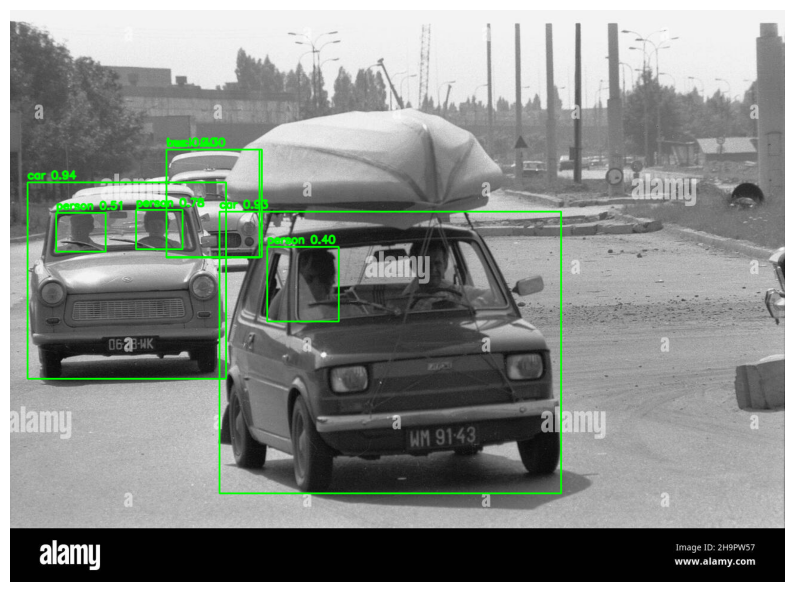

In [4]:
### Ktalog na miniatury

# katalog na miniatury z bounding boxami
YOLO_PREVIEW_DIR = PROJECT_ROOT / "outputs" / "previews" / "yolo"
YOLO_PREVIEW_DIR.mkdir(parents=True, exist_ok=True)

print("YOLO_PREVIEW_DIR:", YOLO_PREVIEW_DIR)

### 3. Wczytywanie modelu YOLO-Medium i funkcje pomocnicze

import torch
import numpy as np
from ultralytics import YOLO
import cv2
from PIL import Image

# Załaduj YOLO-Medium (yolov8m)
model = YOLO("yolov8m.pt")  # medium

# nazwy klas COCO:  {0: 'person', 1: 'bicycle', ...}
CLASS_NAMES = model.names

def run_yolo_on_image(img_path):
    """Wczytuje obraz i wykonuje detekcję YOLO-Medium."""
    img = Image.open(img_path).convert("RGB")
    results = model(img, conf=0.25)[0]
    detections = results.boxes
    return img, detections


def draw_detections(orig_img, detections):
    """Rysuje wykryte obiekty na obrazie."""
    img_np = np.array(orig_img).copy()

    for b in detections:
        cls_id = int(b.cls)
        conf = float(b.conf)
        x1, y1, x2, y2 = map(int, b.xyxy[0])

        # zielony box
        cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)

        label = f"{CLASS_NAMES[cls_id]} {conf:.2f}"
        cv2.putText(
            img_np,
            label,
            (x1, y1 - 6),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 255, 0),
            2,
            cv2.LINE_AA,
        )

    return Image.fromarray(img_np)


# test jednego obrazu
test_img = image_files[0]
orig, dets = run_yolo_on_image(test_img)
vis = draw_detections(orig, dets)

plt.figure(figsize=(10, 10))
plt.imshow(vis)
plt.axis("off")
plt.show()

### 4. Batch YOLO-Medium inference → zapis wyników do CSV

In [5]:
### 4. Batch YOLO-Medium inference → zapis wyników do CSV

import pandas as pd
from tqdm import tqdm

OUTPUT_CSV = OUTPUT_CSV_DIR / "yolo_medium_results.csv"

records = []

for img_path in tqdm(image_files, desc="YOLO-Medium batch", ncols=90):
    try:
        orig, dets = run_yolo_on_image(img_path)
    except Exception:
        continue

    class_ids = [int(b.cls) for b in dets]
    class_names = [CLASS_NAMES[c] for c in class_ids]

    # zliczamy ile obiektów danej klasy
    counts = pd.Series(class_names).value_counts().to_dict()

    records.append({
        "file_path": str(img_path),
        "n_detections": len(class_names),
        "classes": class_names,
        "class_counts": counts,
    })
# zapis miniaturki z bounding boxami### 4. Batch YOLO-Medium inference → zapis wyników do CSV + miniatury

"""
    Uruchamia detekcję YOLO-Medium na wszystkich obrazach z IMAGE_ROOT.

    - Zapisuje pełne wyniki detekcji do CSV (OUTPUT_CSV).
    - Dla każdego obrazu zapisuje miniaturę z bounding boxami w YOLO_PREVIEW_DIR.

    IMAGE_ROOT       – katalog wejściowy z obrazami (Path)
    OUTPUT_CSV_DIR   – katalog na pliki CSV
    OUTPUT_CSV       – plik CSV z pełnymi wynikami detekcji
    YOLO_PREVIEW_DIR – katalog na miniatury z boxami
"""

import pandas as pd
from tqdm import tqdm

OUTPUT_CSV = OUTPUT_CSV_DIR / "yolo_detections.csv"

records = []

for img_path in tqdm(image_files, desc="YOLO-Medium batch", ncols=90):
    try:
        orig, dets = run_yolo_on_image(img_path)
    except Exception:
        continue

    class_ids = [int(b.cls) for b in dets]
    class_names = [CLASS_NAMES[c] for c in class_ids]

    # zliczamy ile obiektów danej klasy
    counts = pd.Series(class_names).value_counts().to_dict()

    records.append({
        "file_path": str(img_path),
        "n_detections": len(class_names),
        "classes": class_names,
        "class_counts": counts,
    })

    # zapis miniaturki z bounding boxami
    thumb = draw_detections(orig, dets)
    thumb.thumbnail((1200, 1200))  # maksymalny wymiar miniatury

    thumb_name = f"thumb_{img_path.stem}.jpg"
    thumb_path = YOLO_PREVIEW_DIR / thumb_name
    thumb.save(thumb_path, "JPEG")

df_yolo = pd.DataFrame(records)

df_yolo.to_csv(OUTPUT_CSV, index=False)
print("Zapisano wyniki:", OUTPUT_CSV)
print("Liczba obrazów przetworzonych:", len(df_yolo))

# zmniejszamy do max 350 px szerokości
thumb.thumbnail((1200, 1200))

thumb_name = f"thumb_{img_path.stem}.jpg"
thumb_path = YOLO_PREVIEW_DIR / thumb_name
thumb.save(thumb_path, "JPEG")

df_yolo = pd.DataFrame(records)

df_yolo.to_csv(OUTPUT_CSV, index=False)
print("Zapisano wyniki:", OUTPUT_CSV)
print("Liczba obrazów przetworzonych:", len(df_yolo))

YOLO-Medium batch:   0%|                                          | 0/134 [00:00<?, ?it/s]


0: 480x640 3 persons, 2 cars, 1 bus, 1 truck, 148.8ms
Speed: 1.7ms preprocess, 148.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:   1%|▎                                 | 1/134 [00:00<00:22,  5.93it/s]


0: 448x640 5 persons, 7 cars, 1 truck, 138.8ms
Speed: 1.3ms preprocess, 138.8ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:   1%|▌                                 | 2/134 [00:00<00:21,  6.28it/s]


0: 352x640 1 car, 112.6ms
Speed: 0.9ms preprocess, 112.6ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)


YOLO-Medium batch:   2%|▊                                 | 3/134 [00:00<00:18,  7.07it/s]


0: 640x608 12 persons, 1 car, 1 truck, 1 tie, 187.1ms
Speed: 1.6ms preprocess, 187.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)


YOLO-Medium batch:   3%|█                                 | 4/134 [00:00<00:21,  6.05it/s]


0: 416x640 3 persons, 4 cars, 132.7ms
Speed: 1.0ms preprocess, 132.7ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)


YOLO-Medium batch:   4%|█▎                                | 5/134 [00:00<00:20,  6.41it/s]


0: 480x640 7 persons, 11 cars, 1 umbrella, 140.4ms
Speed: 1.1ms preprocess, 140.4ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:   4%|█▌                                | 6/134 [00:00<00:19,  6.55it/s]


0: 384x640 2 cars, 124.0ms
Speed: 1.0ms preprocess, 124.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


YOLO-Medium batch:   5%|█▊                                | 7/134 [00:01<00:18,  6.83it/s]


0: 384x640 8 persons, 1 truck, 117.4ms
Speed: 0.9ms preprocess, 117.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


YOLO-Medium batch:   6%|██                                | 8/134 [00:01<00:17,  7.20it/s]


0: 640x416 21 bottles, 127.8ms
Speed: 1.1ms preprocess, 127.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 416)


YOLO-Medium batch:   7%|██▎                               | 9/134 [00:01<00:17,  7.18it/s]


0: 480x640 1 car, 1 truck, 157.5ms
Speed: 1.1ms preprocess, 157.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:   7%|██▍                              | 10/134 [00:01<00:18,  6.75it/s]


0: 480x640 4 persons, 5 cars, 2 trucks, 156.6ms
Speed: 1.4ms preprocess, 156.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:   8%|██▋                              | 11/134 [00:01<00:19,  6.45it/s]


0: 480x640 16 persons, 1 tie, 141.2ms
Speed: 1.2ms preprocess, 141.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:   9%|██▉                              | 12/134 [00:01<00:18,  6.45it/s]


0: 480x640 15 persons, 140.8ms
Speed: 1.3ms preprocess, 140.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:  10%|███▏                             | 13/134 [00:01<00:18,  6.45it/s]


0: 480x640 19 persons, 1 tie, 1 tennis racket, 141.7ms
Speed: 1.1ms preprocess, 141.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:  10%|███▍                             | 14/134 [00:02<00:18,  6.43it/s]


0: 480x640 12 persons, 1 backpack, 1 handbag, 1 potted plant, 135.9ms
Speed: 1.2ms preprocess, 135.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:  11%|███▋                             | 15/134 [00:02<00:18,  6.50it/s]


0: 448x640 13 persons, 1 bench, 1 handbag, 190.4ms
Speed: 3.1ms preprocess, 190.4ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  12%|███▉                             | 16/134 [00:02<00:20,  5.68it/s]


0: 448x640 4 persons, 1 dog, 1 handbag, 136.4ms
Speed: 1.1ms preprocess, 136.4ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  13%|████▏                            | 17/134 [00:02<00:20,  5.83it/s]


0: 576x640 11 persons, 2 motorcycles, 161.5ms
Speed: 1.5ms preprocess, 161.5ms inference, 0.4ms postprocess per image at shape (1, 3, 576, 640)


YOLO-Medium batch:  13%|████▍                            | 18/134 [00:02<00:22,  5.20it/s]


0: 448x640 18 persons, 1 tie, 140.1ms
Speed: 1.1ms preprocess, 140.1ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  14%|████▋                            | 19/134 [00:03<00:20,  5.50it/s]


0: 448x640 17 persons, 5 cars, 3 buss, 1 backpack, 3 handbags, 135.4ms
Speed: 1.1ms preprocess, 135.4ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  15%|████▉                            | 20/134 [00:03<00:19,  5.78it/s]


0: 448x640 5 cars, 1 truck, 134.2ms
Speed: 1.0ms preprocess, 134.2ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  16%|█████▏                           | 21/134 [00:03<00:18,  6.09it/s]


0: 512x640 3 persons, 1 tie, 13 donuts, 5 cakes, 165.7ms
Speed: 1.5ms preprocess, 165.7ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  16%|█████▍                           | 22/134 [00:03<00:21,  5.16it/s]


0: 640x640 5 persons, 1 bicycle, 1 bowl, 187.7ms
Speed: 1.5ms preprocess, 187.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  17%|█████▋                           | 23/134 [00:03<00:22,  4.93it/s]


0: 416x640 1 car, 120.7ms
Speed: 1.0ms preprocess, 120.7ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 640)


YOLO-Medium batch:  18%|█████▉                           | 24/134 [00:03<00:19,  5.52it/s]


0: 640x448 9 persons, 2 cars, 1 airplane, 138.9ms
Speed: 1.1ms preprocess, 138.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:  19%|██████▏                          | 25/134 [00:04<00:18,  5.78it/s]


0: 640x448 (no detections), 136.5ms
Speed: 1.1ms preprocess, 136.5ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:  19%|██████▍                          | 26/134 [00:04<00:18,  5.98it/s]


0: 448x640 1 airplane, 135.0ms
Speed: 1.1ms preprocess, 135.0ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  20%|██████▋                          | 27/134 [00:04<00:17,  6.15it/s]


0: 640x544 (no detections), 149.7ms
Speed: 1.3ms preprocess, 149.7ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 544)


YOLO-Medium batch:  21%|██████▉                          | 28/134 [00:04<00:17,  6.07it/s]


0: 544x640 18 persons, 4 cars, 1 truck, 7 umbrellas, 1 handbag, 1 potted plant, 148.6ms
Speed: 1.5ms preprocess, 148.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)


YOLO-Medium batch:  22%|███████▏                         | 29/134 [00:04<00:19,  5.32it/s]


0: 640x640 10 persons, 3 handbags, 182.8ms
Speed: 1.5ms preprocess, 182.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  22%|███████▍                         | 30/134 [00:05<00:20,  5.08it/s]


0: 448x640 15 persons, 13 cars, 3 toilets, 1 vase, 135.0ms
Speed: 1.1ms preprocess, 135.0ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  23%|███████▋                         | 31/134 [00:05<00:18,  5.45it/s]


0: 448x640 21 persons, 25 cars, 1 bus, 2 trucks, 135.2ms
Speed: 1.1ms preprocess, 135.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  24%|███████▉                         | 32/134 [00:05<00:17,  5.74it/s]


0: 448x640 5 persons, 1 banana, 134.2ms
Speed: 1.3ms preprocess, 134.2ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  25%|████████▏                        | 33/134 [00:05<00:17,  5.61it/s]


0: 448x640 4 persons, 2 cars, 1 truck, 1 dog, 135.4ms
Speed: 1.1ms preprocess, 135.4ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  25%|████████▎                        | 34/134 [00:05<00:17,  5.86it/s]


0: 448x640 16 persons, 1 tie, 1 donut, 135.6ms
Speed: 1.1ms preprocess, 135.6ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  26%|████████▌                        | 35/134 [00:05<00:16,  6.07it/s]


0: 512x640 9 persons, 164.6ms
Speed: 1.2ms preprocess, 164.6ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  27%|████████▊                        | 36/134 [00:06<00:16,  5.91it/s]


0: 576x640 6 persons, 1 car, 1 dog, 1 sports ball, 2 cups, 158.8ms
Speed: 1.6ms preprocess, 158.8ms inference, 0.4ms postprocess per image at shape (1, 3, 576, 640)


YOLO-Medium batch:  28%|█████████                        | 37/134 [00:06<00:18,  5.32it/s]


0: 544x640 10 persons, 1 bicycle, 1 car, 4 benchs, 148.8ms
Speed: 1.5ms preprocess, 148.8ms inference, 0.4ms postprocess per image at shape (1, 3, 544, 640)


YOLO-Medium batch:  28%|█████████▎                       | 38/134 [00:06<00:19,  4.90it/s]


0: 544x640 5 persons, 1 bicycle, 4 benchs, 1 suitcase, 149.3ms
Speed: 1.5ms preprocess, 149.3ms inference, 0.4ms postprocess per image at shape (1, 3, 544, 640)


YOLO-Medium batch:  29%|█████████▌                       | 39/134 [00:06<00:20,  4.61it/s]


0: 608x640 4 persons, 2 handbags, 1 bottle, 2 cell phones, 172.1ms
Speed: 1.6ms preprocess, 172.1ms inference, 0.4ms postprocess per image at shape (1, 3, 608, 640)


YOLO-Medium batch:  30%|█████████▊                       | 40/134 [00:07<00:21,  4.36it/s]


0: 512x640 9 persons, 1 car, 3 buss, 1 truck, 164.7ms
Speed: 1.5ms preprocess, 164.7ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  31%|██████████                       | 41/134 [00:07<00:22,  4.15it/s]


0: 640x608 6 persons, 1 bus, 170.6ms
Speed: 1.6ms preprocess, 170.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 608)


YOLO-Medium batch:  31%|██████████▎                      | 42/134 [00:07<00:22,  4.04it/s]


0: 640x512 1 person, 165.3ms
Speed: 1.4ms preprocess, 165.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 512)


YOLO-Medium batch:  32%|██████████▌                      | 43/134 [00:07<00:21,  4.15it/s]


0: 640x480 2 persons, 1 bicycle, 143.8ms
Speed: 1.4ms preprocess, 143.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 480)


YOLO-Medium batch:  33%|██████████▊                      | 44/134 [00:07<00:19,  4.63it/s]


0: 512x640 1 person, 1 bear, 1 sink, 1 scissors, 166.0ms
Speed: 1.5ms preprocess, 166.0ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  34%|███████████                      | 45/134 [00:08<00:20,  4.27it/s]


0: 448x640 2 persons, 1 car, 132.6ms
Speed: 1.3ms preprocess, 132.6ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  34%|███████████▎                     | 46/134 [00:08<00:18,  4.78it/s]


0: 576x640 3 persons, 1 tie, 1 suitcase, 159.1ms
Speed: 1.6ms preprocess, 159.1ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)


YOLO-Medium batch:  35%|███████████▌                     | 47/134 [00:08<00:18,  4.63it/s]


0: 640x640 7 persons, 1 handbag, 1 suitcase, 181.8ms
Speed: 1.7ms preprocess, 181.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  36%|███████████▊                     | 48/134 [00:08<00:19,  4.37it/s]


0: 640x640 10 persons, 1 handbag, 193.1ms
Speed: 1.7ms preprocess, 193.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  37%|████████████                     | 49/134 [00:09<00:19,  4.36it/s]


0: 640x640 4 persons, 1 fork, 1 bowl, 1 chair, 185.4ms
Speed: 1.5ms preprocess, 185.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  37%|████████████▎                    | 50/134 [00:09<00:19,  4.41it/s]


0: 640x640 1 person, 1 umbrella, 3 bottles, 2 clocks, 183.3ms
Speed: 1.7ms preprocess, 183.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  38%|████████████▌                    | 51/134 [00:09<00:18,  4.39it/s]


0: 640x640 10 persons, 3 bicycles, 1 bottle, 183.1ms
Speed: 1.7ms preprocess, 183.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  39%|████████████▊                    | 52/134 [00:09<00:19,  4.25it/s]


0: 480x640 1 sheep, 134.8ms
Speed: 1.1ms preprocess, 134.8ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:  40%|█████████████                    | 53/134 [00:09<00:16,  4.81it/s]


0: 640x480 4 persons, 1 dog, 1 sheep, 1 sports ball, 135.7ms
Speed: 1.3ms preprocess, 135.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 480)


YOLO-Medium batch:  40%|█████████████▎                   | 54/134 [00:10<00:15,  5.26it/s]


0: 640x640 6 persons, 183.7ms
Speed: 1.7ms preprocess, 183.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  41%|█████████████▌                   | 55/134 [00:10<00:15,  5.06it/s]


0: 640x480 2 persons, 1 tie, 8 bottles, 134.3ms
Speed: 1.3ms preprocess, 134.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 480)


YOLO-Medium batch:  42%|█████████████▊                   | 56/134 [00:10<00:15,  5.08it/s]


0: 512x640 8 persons, 2 sheeps, 164.0ms
Speed: 1.4ms preprocess, 164.0ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  43%|██████████████                   | 57/134 [00:10<00:15,  4.87it/s]


0: 640x512 3 persons, 165.4ms
Speed: 1.5ms preprocess, 165.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 512)


YOLO-Medium batch:  43%|██████████████▎                  | 58/134 [00:10<00:14,  5.07it/s]


0: 480x640 3 persons, 1 train, 134.7ms
Speed: 1.1ms preprocess, 134.7ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:  44%|██████████████▌                  | 59/134 [00:11<00:13,  5.52it/s]


0: 640x416 1 person, 124.4ms
Speed: 1.2ms preprocess, 124.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 416)


YOLO-Medium batch:  45%|██████████████▊                  | 60/134 [00:11<00:12,  5.94it/s]


0: 416x640 3 persons, 1 horse, 123.7ms
Speed: 1.2ms preprocess, 123.7ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)


YOLO-Medium batch:  46%|███████████████                  | 61/134 [00:11<00:11,  6.30it/s]


0: 608x640 2 persons, 168.5ms
Speed: 1.6ms preprocess, 168.5ms inference, 0.4ms postprocess per image at shape (1, 3, 608, 640)


YOLO-Medium batch:  46%|███████████████▎                 | 62/134 [00:11<00:13,  5.45it/s]


0: 640x448 1 person, 137.8ms
Speed: 1.2ms preprocess, 137.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:  47%|███████████████▌                 | 63/134 [00:11<00:12,  5.77it/s]


0: 512x640 2 persons, 2 horses, 202.7ms
Speed: 1.2ms preprocess, 202.7ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  48%|███████████████▊                 | 64/134 [00:11<00:13,  5.36it/s]


0: 576x640 4 persons, 3 cups, 1 bowl, 158.4ms
Speed: 1.5ms preprocess, 158.4ms inference, 0.4ms postprocess per image at shape (1, 3, 576, 640)


YOLO-Medium batch:  49%|████████████████                 | 65/134 [00:12<00:14,  4.76it/s]


0: 576x640 3 persons, 2 birds, 2 cups, 1 bowl, 158.3ms
Speed: 1.5ms preprocess, 158.3ms inference, 0.4ms postprocess per image at shape (1, 3, 576, 640)


YOLO-Medium batch:  49%|████████████████▎                | 66/134 [00:12<00:15,  4.45it/s]


0: 512x640 2 persons, 2 suitcases, 4 cups, 1 tv, 163.5ms
Speed: 1.4ms preprocess, 163.5ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  50%|████████████████▌                | 67/134 [00:12<00:16,  4.12it/s]


0: 640x640 2 persons, 1 bed, 183.9ms
Speed: 1.7ms preprocess, 183.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  51%|████████████████▋                | 68/134 [00:12<00:15,  4.16it/s]


0: 640x640 2 persons, 1 donut, 182.3ms
Speed: 1.7ms preprocess, 182.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  51%|████████████████▉                | 69/134 [00:13<00:15,  4.21it/s]


0: 640x640 2 persons, 1 tie, 2 bowls, 1 laptop, 1 oven, 2 books, 182.8ms
Speed: 1.7ms preprocess, 182.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  52%|█████████████████▏               | 70/134 [00:13<00:15,  4.23it/s]


0: 640x640 29 persons, 1 car, 1 handbag, 1 clock, 182.6ms
Speed: 1.5ms preprocess, 182.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  53%|█████████████████▍               | 71/134 [00:13<00:14,  4.36it/s]


0: 640x640 7 persons, 2 handbags, 181.9ms
Speed: 1.7ms preprocess, 181.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  54%|█████████████████▋               | 72/134 [00:13<00:14,  4.18it/s]


0: 640x640 1 person, 13 donuts, 183.2ms
Speed: 1.6ms preprocess, 183.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  54%|█████████████████▉               | 73/134 [00:14<00:13,  4.36it/s]


0: 448x640 1 person, 3 cars, 135.4ms
Speed: 1.2ms preprocess, 135.4ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  55%|██████████████████▏              | 74/134 [00:14<00:12,  4.85it/s]


0: 416x640 18 persons, 1 stop sign, 1 dog, 1 umbrella, 2 handbags, 2 ties, 124.7ms
Speed: 1.0ms preprocess, 124.7ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)


YOLO-Medium batch:  56%|██████████████████▍              | 75/134 [00:14<00:11,  5.26it/s]


0: 640x640 2 persons, 3 cars, 183.3ms
Speed: 1.7ms preprocess, 183.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  57%|██████████████████▋              | 76/134 [00:14<00:11,  5.21it/s]


0: 640x640 2 persons, 1 tie, 1 pizza, 2 chairs, 183.3ms
Speed: 1.5ms preprocess, 183.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  57%|██████████████████▉              | 77/134 [00:14<00:11,  5.10it/s]


0: 512x640 3 persons, 1 motorcycle, 163.2ms
Speed: 1.5ms preprocess, 163.2ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  58%|███████████████████▏             | 78/134 [00:15<00:11,  4.69it/s]


0: 448x640 2 persons, 1 bus, 1 truck, 136.1ms
Speed: 1.0ms preprocess, 136.1ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  59%|███████████████████▍             | 79/134 [00:15<00:10,  5.18it/s]


0: 512x640 3 persons, 5 cars, 164.2ms
Speed: 1.4ms preprocess, 164.2ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  60%|███████████████████▋             | 80/134 [00:15<00:10,  5.31it/s]


0: 640x448 2 cars, 1 clock, 136.3ms
Speed: 1.0ms preprocess, 136.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:  60%|███████████████████▉             | 81/134 [00:15<00:09,  5.73it/s]


0: 448x640 4 persons, 6 cars, 1 bus, 2 trucks, 136.4ms
Speed: 1.0ms preprocess, 136.4ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  61%|████████████████████▏            | 82/134 [00:15<00:08,  6.05it/s]


0: 448x640 3 persons, 1 car, 136.1ms
Speed: 1.1ms preprocess, 136.1ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  62%|████████████████████▍            | 83/134 [00:15<00:08,  6.28it/s]


0: 640x640 1 person, 1 car, 1 truck, 1 surfboard, 183.8ms
Speed: 1.5ms preprocess, 183.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  63%|████████████████████▋            | 84/134 [00:16<00:08,  5.87it/s]


0: 384x640 7 persons, 1 bicycle, 2 cars, 1 truck, 1 handbag, 1 chair, 118.8ms
Speed: 0.9ms preprocess, 118.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


YOLO-Medium batch:  63%|████████████████████▉            | 85/134 [00:16<00:07,  6.34it/s]


0: 576x640 7 persons, 1 car, 159.2ms
Speed: 1.3ms preprocess, 159.2ms inference, 0.4ms postprocess per image at shape (1, 3, 576, 640)


YOLO-Medium batch:  64%|█████████████████████▏           | 86/134 [00:16<00:07,  6.20it/s]


0: 480x640 2 persons, 1 car, 134.2ms
Speed: 0.6ms preprocess, 134.2ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:  65%|█████████████████████▍           | 87/134 [00:16<00:07,  6.44it/s]


0: 480x640 7 persons, 1 car, 134.0ms
Speed: 1.0ms preprocess, 134.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:  66%|█████████████████████▋           | 88/134 [00:16<00:06,  6.63it/s]


0: 544x640 1 person, 3 cars, 150.6ms
Speed: 1.3ms preprocess, 150.6ms inference, 0.4ms postprocess per image at shape (1, 3, 544, 640)


YOLO-Medium batch:  66%|█████████████████████▉           | 89/134 [00:16<00:06,  6.49it/s]


0: 384x640 3 persons, 1 car, 159.0ms
Speed: 0.9ms preprocess, 159.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


YOLO-Medium batch:  67%|██████████████████████▏          | 90/134 [00:16<00:06,  6.34it/s]


0: 480x640 4 persons, 1 car, 134.4ms
Speed: 1.2ms preprocess, 134.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:  68%|██████████████████████▍          | 91/134 [00:17<00:06,  6.50it/s]


0: 448x640 1 person, 1 car, 1 truck, 134.8ms
Speed: 1.1ms preprocess, 134.8ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  69%|██████████████████████▋          | 92/134 [00:17<00:06,  6.62it/s]


0: 544x640 3 persons, 5 cars, 150.4ms
Speed: 1.5ms preprocess, 150.4ms inference, 0.4ms postprocess per image at shape (1, 3, 544, 640)


YOLO-Medium batch:  69%|██████████████████████▉          | 93/134 [00:17<00:06,  6.21it/s]


0: 416x640 1 person, 1 car, 1 handbag, 123.6ms
Speed: 1.1ms preprocess, 123.6ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)


YOLO-Medium batch:  70%|███████████████████████▏         | 94/134 [00:17<00:06,  6.52it/s]


0: 384x640 1 person, 1 car, 119.7ms
Speed: 0.9ms preprocess, 119.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


YOLO-Medium batch:  71%|███████████████████████▍         | 95/134 [00:17<00:05,  6.88it/s]


0: 416x640 1 person, 1 car, 124.4ms
Speed: 1.0ms preprocess, 124.4ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)


YOLO-Medium batch:  72%|███████████████████████▋         | 96/134 [00:17<00:05,  7.09it/s]


0: 640x640 19 persons, 5 cars, 1 handbag, 184.3ms
Speed: 1.8ms preprocess, 184.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  72%|███████████████████████▉         | 97/134 [00:18<00:06,  6.14it/s]


0: 480x640 1 person, 1 car, 1 tennis racket, 134.9ms
Speed: 1.2ms preprocess, 134.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:  73%|████████████████████████▏        | 98/134 [00:18<00:05,  6.35it/s]


0: 416x640 7 persons, 1 car, 1 truck, 2 traffic lights, 122.8ms
Speed: 1.2ms preprocess, 122.8ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)


YOLO-Medium batch:  74%|████████████████████████▍        | 99/134 [00:18<00:05,  6.55it/s]


0: 640x640 3 persons, 10 cars, 1 clock, 183.1ms
Speed: 1.6ms preprocess, 183.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  75%|███████████████████████▉        | 100/134 [00:18<00:05,  6.03it/s]


0: 640x640 1 person, 1 baseball bat, 182.5ms
Speed: 1.6ms preprocess, 182.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  75%|████████████████████████        | 101/134 [00:18<00:05,  5.70it/s]


0: 384x640 10 persons, 2 cars, 1 truck, 1 handbag, 118.7ms
Speed: 1.1ms preprocess, 118.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


YOLO-Medium batch:  76%|████████████████████████▎       | 102/134 [00:18<00:05,  6.08it/s]


0: 448x640 1 person, 14 cars, 1 truck, 132.5ms
Speed: 1.3ms preprocess, 132.5ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  77%|████████████████████████▌       | 103/134 [00:18<00:04,  6.20it/s]


0: 640x640 8 persons, 1 car, 2 buss, 1 truck, 181.2ms
Speed: 2.0ms preprocess, 181.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  78%|████████████████████████▊       | 104/134 [00:19<00:05,  5.38it/s]


0: 448x640 5 persons, 9 cars, 1 bus, 134.6ms
Speed: 0.9ms preprocess, 134.6ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  78%|█████████████████████████       | 105/134 [00:19<00:05,  5.80it/s]


0: 416x640 1 person, 1 car, 122.5ms
Speed: 1.5ms preprocess, 122.5ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)


YOLO-Medium batch:  79%|█████████████████████████▎      | 106/134 [00:19<00:04,  5.69it/s]


0: 480x640 1 car, 134.4ms
Speed: 1.2ms preprocess, 134.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:  80%|█████████████████████████▌      | 107/134 [00:19<00:04,  6.00it/s]


0: 448x640 3 cars, 134.9ms
Speed: 1.2ms preprocess, 134.9ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  81%|█████████████████████████▊      | 108/134 [00:19<00:04,  6.00it/s]


0: 448x640 2 trucks, 135.0ms
Speed: 1.1ms preprocess, 135.0ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  81%|██████████████████████████      | 109/134 [00:20<00:04,  6.24it/s]


0: 480x640 1 truck, 1 bench, 134.5ms
Speed: 1.0ms preprocess, 134.5ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:  82%|██████████████████████████▎     | 110/134 [00:20<00:03,  6.46it/s]


0: 416x640 4 persons, 1 car, 1 motorcycle, 4 trucks, 2 handbags, 123.9ms
Speed: 1.2ms preprocess, 123.9ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)


YOLO-Medium batch:  83%|██████████████████████████▌     | 111/134 [00:20<00:03,  6.57it/s]


0: 448x640 13 persons, 3 handbags, 1 suitcase, 134.5ms
Speed: 1.1ms preprocess, 134.5ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  84%|██████████████████████████▋     | 112/134 [00:20<00:03,  6.66it/s]


0: 512x640 16 persons, 1 traffic light, 2 umbrellas, 3 handbags, 163.5ms
Speed: 1.3ms preprocess, 163.5ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  84%|██████████████████████████▉     | 113/134 [00:20<00:03,  6.33it/s]


0: 448x640 6 persons, 2 traffic lights, 2 umbrellas, 1 cell phone, 134.5ms
Speed: 1.1ms preprocess, 134.5ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  85%|███████████████████████████▏    | 114/134 [00:20<00:03,  6.51it/s]


0: 448x640 2 persons, 1 backpack, 174.6ms
Speed: 1.1ms preprocess, 174.6ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  86%|███████████████████████████▍    | 115/134 [00:20<00:03,  6.14it/s]


0: 608x640 4 persons, 1 backpack, 2 handbags, 1 bottle, 2 cell phones, 167.3ms
Speed: 1.5ms preprocess, 167.3ms inference, 0.4ms postprocess per image at shape (1, 3, 608, 640)


YOLO-Medium batch:  87%|███████████████████████████▋    | 116/134 [00:21<00:03,  5.95it/s]


0: 608x640 3 persons, 1 car, 1 truck, 2 umbrellas, 2 handbags, 1 potted plant, 1 vase, 167.8ms
Speed: 1.5ms preprocess, 167.8ms inference, 0.4ms postprocess per image at shape (1, 3, 608, 640)


YOLO-Medium batch:  87%|███████████████████████████▉    | 117/134 [00:21<00:02,  5.81it/s]


0: 640x448 3 persons, 1 bench, 136.6ms
Speed: 1.2ms preprocess, 136.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:  88%|████████████████████████████▏   | 118/134 [00:21<00:02,  6.00it/s]


0: 640x640 5 persons, 2 cars, 1 truck, 2 handbags, 183.8ms
Speed: 1.4ms preprocess, 183.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  89%|████████████████████████████▍   | 119/134 [00:21<00:02,  5.73it/s]


0: 640x640 14 persons, 3 cars, 2 buss, 1 truck, 4 handbags, 183.8ms
Speed: 1.4ms preprocess, 183.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  90%|████████████████████████████▋   | 120/134 [00:21<00:02,  5.55it/s]


0: 416x640 1 person, 1 car, 1 truck, 124.1ms
Speed: 1.0ms preprocess, 124.1ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)


YOLO-Medium batch:  90%|████████████████████████████▉   | 121/134 [00:21<00:02,  6.02it/s]


0: 448x640 4 persons, 3 cars, 3 trucks, 134.2ms
Speed: 1.3ms preprocess, 134.2ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  91%|█████████████████████████████▏  | 122/134 [00:22<00:01,  6.11it/s]


0: 640x448 1 person, 1 baseball bat, 137.3ms
Speed: 1.1ms preprocess, 137.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:  92%|█████████████████████████████▎  | 123/134 [00:22<00:01,  6.28it/s]


0: 640x448 3 persons, 136.2ms
Speed: 1.2ms preprocess, 136.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:  93%|█████████████████████████████▌  | 124/134 [00:22<00:01,  6.36it/s]


0: 640x640 2 persons, 1 truck, 182.8ms
Speed: 1.2ms preprocess, 182.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  93%|█████████████████████████████▊  | 125/134 [00:22<00:01,  6.01it/s]


0: 352x640 9 persons, 2 cars, 103.1ms
Speed: 1.1ms preprocess, 103.1ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)


YOLO-Medium batch:  94%|██████████████████████████████  | 126/134 [00:22<00:01,  6.43it/s]


0: 640x448 3 persons, 3 chairs, 137.2ms
Speed: 1.2ms preprocess, 137.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:  95%|██████████████████████████████▎ | 127/134 [00:22<00:01,  6.45it/s]


0: 448x640 1 car, 1 boat, 135.9ms
Speed: 1.0ms preprocess, 135.9ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  96%|██████████████████████████████▌ | 128/134 [00:23<00:00,  6.60it/s]


0: 448x640 5 persons, 3 cars, 1 truck, 1 surfboard, 134.9ms
Speed: 1.2ms preprocess, 134.9ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  96%|██████████████████████████████▊ | 129/134 [00:23<00:00,  6.59it/s]


0: 352x640 2 persons, 6 cars, 103.2ms
Speed: 1.1ms preprocess, 103.2ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)


YOLO-Medium batch:  97%|███████████████████████████████ | 130/134 [00:23<00:00,  6.85it/s]


0: 512x640 12 persons, 1 car, 1 truck, 1 stop sign, 1 handbag, 165.2ms
Speed: 1.0ms preprocess, 165.2ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  98%|███████████████████████████████▎| 131/134 [00:23<00:00,  6.51it/s]


0: 640x640 2 cars, 184.3ms
Speed: 1.3ms preprocess, 184.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  99%|███████████████████████████████▌| 132/134 [00:23<00:00,  6.06it/s]


0: 448x640 8 persons, 1 truck, 135.0ms
Speed: 1.0ms preprocess, 135.0ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  99%|███████████████████████████████▊| 133/134 [00:23<00:00,  6.31it/s]


0: 384x640 2 persons, 17 cars, 1 bus, 6 trucks, 118.2ms
Speed: 1.0ms preprocess, 118.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


YOLO-Medium batch:   0%|                                          | 0/134 [00:00<?, ?it/s]


0: 480x640 3 persons, 2 cars, 1 bus, 1 truck, 135.5ms
Speed: 1.3ms preprocess, 135.5ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:   1%|▎                                 | 1/134 [00:00<00:21,  6.12it/s]


0: 448x640 5 persons, 7 cars, 1 truck, 135.7ms
Speed: 1.1ms preprocess, 135.7ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:   1%|▌                                 | 2/134 [00:00<00:20,  6.35it/s]


0: 352x640 1 car, 107.6ms
Speed: 0.9ms preprocess, 107.6ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)


YOLO-Medium batch:   2%|▊                                 | 3/134 [00:00<00:18,  7.19it/s]


0: 640x608 12 persons, 1 car, 1 truck, 1 tie, 169.4ms
Speed: 1.6ms preprocess, 169.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 608)


YOLO-Medium batch:   3%|█                                 | 4/134 [00:00<00:21,  6.08it/s]


0: 416x640 3 persons, 4 cars, 124.2ms
Speed: 0.9ms preprocess, 124.2ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)


YOLO-Medium batch:   4%|█▎                                | 5/134 [00:00<00:19,  6.53it/s]


0: 480x640 7 persons, 11 cars, 1 umbrella, 164.3ms
Speed: 1.0ms preprocess, 164.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:   4%|█▌                                | 6/134 [00:00<00:20,  6.27it/s]


0: 384x640 2 cars, 157.1ms
Speed: 1.0ms preprocess, 157.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


YOLO-Medium batch:   5%|█▊                                | 7/134 [00:01<00:20,  6.15it/s]


0: 384x640 8 persons, 1 truck, 118.0ms
Speed: 0.9ms preprocess, 118.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


YOLO-Medium batch:   6%|██                                | 8/134 [00:01<00:18,  6.64it/s]


0: 640x416 21 bottles, 125.3ms
Speed: 1.0ms preprocess, 125.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 416)


YOLO-Medium batch:   7%|██▎                               | 9/134 [00:01<00:18,  6.81it/s]


0: 480x640 1 car, 1 truck, 131.4ms
Speed: 1.1ms preprocess, 131.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:   7%|██▍                              | 10/134 [00:01<00:18,  6.85it/s]


0: 480x640 4 persons, 5 cars, 2 trucks, 134.8ms
Speed: 1.3ms preprocess, 134.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:   8%|██▋                              | 11/134 [00:01<00:18,  6.65it/s]


0: 480x640 16 persons, 1 tie, 134.4ms
Speed: 1.2ms preprocess, 134.4ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:   9%|██▉                              | 12/134 [00:01<00:18,  6.63it/s]


0: 480x640 15 persons, 134.4ms
Speed: 1.2ms preprocess, 134.4ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:  10%|███▏                             | 13/134 [00:01<00:18,  6.62it/s]


0: 480x640 19 persons, 1 tie, 1 tennis racket, 133.7ms
Speed: 1.1ms preprocess, 133.7ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:  10%|███▍                             | 14/134 [00:02<00:18,  6.61it/s]


0: 480x640 12 persons, 1 backpack, 1 handbag, 1 potted plant, 135.1ms
Speed: 1.1ms preprocess, 135.1ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:  11%|███▋                             | 15/134 [00:02<00:18,  6.60it/s]


0: 448x640 13 persons, 1 bench, 1 handbag, 136.3ms
Speed: 1.1ms preprocess, 136.3ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  12%|███▉                             | 16/134 [00:02<00:18,  6.41it/s]


0: 448x640 4 persons, 1 dog, 1 handbag, 134.6ms
Speed: 1.2ms preprocess, 134.6ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  13%|████▏                            | 17/134 [00:02<00:18,  6.30it/s]


0: 576x640 11 persons, 2 motorcycles, 159.7ms
Speed: 1.5ms preprocess, 159.7ms inference, 0.4ms postprocess per image at shape (1, 3, 576, 640)


YOLO-Medium batch:  13%|████▍                            | 18/134 [00:02<00:22,  5.25it/s]


0: 448x640 18 persons, 1 tie, 135.2ms
Speed: 1.1ms preprocess, 135.2ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  14%|████▋                            | 19/134 [00:03<00:20,  5.55it/s]


0: 448x640 17 persons, 5 cars, 3 buss, 1 backpack, 3 handbags, 199.8ms
Speed: 1.1ms preprocess, 199.8ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  15%|████▉                            | 20/134 [00:03<00:21,  5.19it/s]


0: 448x640 5 cars, 1 truck, 134.5ms
Speed: 1.1ms preprocess, 134.5ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  16%|█████▏                           | 21/134 [00:03<00:20,  5.59it/s]


0: 512x640 3 persons, 1 tie, 13 donuts, 5 cakes, 164.6ms
Speed: 1.5ms preprocess, 164.6ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  16%|█████▍                           | 22/134 [00:03<00:23,  4.72it/s]


0: 640x640 5 persons, 1 bicycle, 1 bowl, 191.0ms
Speed: 1.5ms preprocess, 191.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  17%|█████▋                           | 23/134 [00:03<00:24,  4.59it/s]


0: 416x640 1 car, 122.5ms
Speed: 1.0ms preprocess, 122.5ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)


YOLO-Medium batch:  18%|█████▉                           | 24/134 [00:04<00:21,  5.17it/s]


0: 640x448 9 persons, 2 cars, 1 airplane, 137.1ms
Speed: 1.1ms preprocess, 137.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:  19%|██████▏                          | 25/134 [00:04<00:19,  5.49it/s]


0: 640x448 (no detections), 136.2ms
Speed: 1.1ms preprocess, 136.2ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:  19%|██████▍                          | 26/134 [00:04<00:18,  5.74it/s]


0: 448x640 1 airplane, 152.5ms
Speed: 11.6ms preprocess, 152.5ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  20%|██████▋                          | 27/134 [00:04<00:19,  5.58it/s]


0: 640x544 (no detections), 152.1ms
Speed: 1.3ms preprocess, 152.1ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 544)


YOLO-Medium batch:  21%|██████▉                          | 28/134 [00:04<00:18,  5.61it/s]


0: 544x640 18 persons, 4 cars, 1 truck, 7 umbrellas, 1 handbag, 1 potted plant, 148.5ms
Speed: 1.5ms preprocess, 148.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)


YOLO-Medium batch:  22%|███████▏                         | 29/134 [00:05<00:21,  4.85it/s]


0: 640x640 10 persons, 3 handbags, 183.9ms
Speed: 1.5ms preprocess, 183.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  22%|███████▍                         | 30/134 [00:05<00:22,  4.72it/s]


0: 448x640 15 persons, 13 cars, 3 toilets, 1 vase, 136.8ms
Speed: 1.7ms preprocess, 136.8ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  23%|███████▋                         | 31/134 [00:05<00:20,  5.09it/s]


0: 448x640 21 persons, 25 cars, 1 bus, 2 trucks, 135.4ms
Speed: 1.1ms preprocess, 135.4ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  24%|███████▉                         | 32/134 [00:05<00:18,  5.39it/s]


0: 448x640 5 persons, 1 banana, 134.1ms
Speed: 1.3ms preprocess, 134.1ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  25%|████████▏                        | 33/134 [00:05<00:19,  5.19it/s]


0: 448x640 4 persons, 2 cars, 1 truck, 1 dog, 134.5ms
Speed: 1.1ms preprocess, 134.5ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  25%|████████▎                        | 34/134 [00:05<00:18,  5.51it/s]


0: 448x640 16 persons, 1 tie, 1 donut, 135.1ms
Speed: 1.1ms preprocess, 135.1ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  26%|████████▌                        | 35/134 [00:06<00:17,  5.75it/s]


0: 512x640 9 persons, 164.4ms
Speed: 1.2ms preprocess, 164.4ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  27%|████████▊                        | 36/134 [00:06<00:17,  5.65it/s]


0: 576x640 6 persons, 1 car, 1 dog, 1 sports ball, 2 cups, 158.4ms
Speed: 1.6ms preprocess, 158.4ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)


YOLO-Medium batch:  28%|█████████                        | 37/134 [00:06<00:19,  4.96it/s]


0: 544x640 10 persons, 1 bicycle, 1 car, 4 benchs, 149.6ms
Speed: 1.5ms preprocess, 149.6ms inference, 0.4ms postprocess per image at shape (1, 3, 544, 640)


YOLO-Medium batch:  28%|█████████▎                       | 38/134 [00:06<00:21,  4.48it/s]


0: 544x640 5 persons, 1 bicycle, 4 benchs, 1 suitcase, 151.5ms
Speed: 1.5ms preprocess, 151.5ms inference, 0.4ms postprocess per image at shape (1, 3, 544, 640)


YOLO-Medium batch:  29%|█████████▌                       | 39/134 [00:07<00:22,  4.19it/s]


0: 608x640 4 persons, 2 handbags, 1 bottle, 2 cell phones, 167.7ms
Speed: 1.6ms preprocess, 167.7ms inference, 0.5ms postprocess per image at shape (1, 3, 608, 640)


YOLO-Medium batch:  30%|█████████▊                       | 40/134 [00:07<00:23,  4.00it/s]


0: 512x640 9 persons, 1 car, 3 buss, 1 truck, 164.4ms
Speed: 1.4ms preprocess, 164.4ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  31%|██████████                       | 41/134 [00:07<00:24,  3.79it/s]


0: 640x608 6 persons, 1 bus, 175.1ms
Speed: 1.8ms preprocess, 175.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 608)


YOLO-Medium batch:  31%|██████████▎                      | 42/134 [00:07<00:24,  3.83it/s]


0: 640x512 1 person, 165.3ms
Speed: 1.3ms preprocess, 165.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 512)


YOLO-Medium batch:  32%|██████████▌                      | 43/134 [00:08<00:23,  3.91it/s]


0: 640x480 2 persons, 1 bicycle, 134.9ms
Speed: 1.3ms preprocess, 134.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


YOLO-Medium batch:  33%|██████████▊                      | 44/134 [00:08<00:20,  4.39it/s]


0: 512x640 1 person, 1 bear, 1 sink, 1 scissors, 163.5ms
Speed: 1.5ms preprocess, 163.5ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  34%|███████████                      | 45/134 [00:08<00:22,  4.01it/s]


0: 448x640 2 persons, 1 car, 134.5ms
Speed: 1.4ms preprocess, 134.5ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  34%|███████████▎                     | 46/134 [00:08<00:20,  4.39it/s]


0: 576x640 3 persons, 1 tie, 1 suitcase, 158.4ms
Speed: 1.6ms preprocess, 158.4ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)


YOLO-Medium batch:  35%|███████████▌                     | 47/134 [00:09<00:21,  4.06it/s]


0: 640x640 7 persons, 1 handbag, 1 suitcase, 187.9ms
Speed: 1.9ms preprocess, 187.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  36%|███████████▊                     | 48/134 [00:09<00:22,  3.84it/s]


0: 640x640 10 persons, 1 handbag, 182.2ms
Speed: 1.5ms preprocess, 182.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  37%|████████████                     | 49/134 [00:09<00:21,  4.01it/s]


0: 640x640 4 persons, 1 fork, 1 bowl, 1 chair, 182.1ms
Speed: 1.5ms preprocess, 182.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  37%|████████████▎                    | 50/134 [00:09<00:20,  4.14it/s]


0: 640x640 1 person, 1 umbrella, 3 bottles, 2 clocks, 179.9ms
Speed: 1.6ms preprocess, 179.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  38%|████████████▌                    | 51/134 [00:10<00:20,  4.10it/s]


0: 640x640 10 persons, 3 bicycles, 1 bottle, 181.0ms
Speed: 1.8ms preprocess, 181.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  39%|████████████▊                    | 52/134 [00:10<00:20,  3.94it/s]


0: 480x640 1 sheep, 134.3ms
Speed: 1.1ms preprocess, 134.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:  40%|█████████████                    | 53/134 [00:10<00:17,  4.50it/s]


0: 640x480 4 persons, 1 dog, 1 sheep, 1 sports ball, 140.8ms
Speed: 1.5ms preprocess, 140.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 480)


YOLO-Medium batch:  40%|█████████████▎                   | 54/134 [00:10<00:16,  4.84it/s]


0: 640x640 6 persons, 184.5ms
Speed: 1.5ms preprocess, 184.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  41%|█████████████▌                   | 55/134 [00:10<00:16,  4.75it/s]


0: 640x480 2 persons, 1 tie, 8 bottles, 136.1ms
Speed: 1.4ms preprocess, 136.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 480)


YOLO-Medium batch:  42%|█████████████▊                   | 56/134 [00:11<00:16,  4.67it/s]


0: 512x640 8 persons, 2 sheeps, 162.0ms
Speed: 1.4ms preprocess, 162.0ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  43%|██████████████                   | 57/134 [00:11<00:17,  4.44it/s]


0: 640x512 3 persons, 163.6ms
Speed: 1.3ms preprocess, 163.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 512)


YOLO-Medium batch:  43%|██████████████▎                  | 58/134 [00:11<00:16,  4.66it/s]


0: 480x640 3 persons, 1 train, 134.7ms
Speed: 1.2ms preprocess, 134.7ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:  44%|██████████████▌                  | 59/134 [00:11<00:14,  5.15it/s]


0: 640x416 1 person, 127.3ms
Speed: 1.2ms preprocess, 127.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 416)


YOLO-Medium batch:  45%|██████████████▊                  | 60/134 [00:11<00:13,  5.45it/s]


0: 416x640 3 persons, 1 horse, 125.2ms
Speed: 1.1ms preprocess, 125.2ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)


YOLO-Medium batch:  46%|███████████████                  | 61/134 [00:11<00:12,  5.86it/s]


0: 608x640 2 persons, 167.9ms
Speed: 1.6ms preprocess, 167.9ms inference, 0.4ms postprocess per image at shape (1, 3, 608, 640)


YOLO-Medium batch:  46%|███████████████▎                 | 62/134 [00:12<00:14,  5.02it/s]


0: 640x448 1 person, 138.1ms
Speed: 1.2ms preprocess, 138.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:  47%|███████████████▌                 | 63/134 [00:12<00:13,  5.29it/s]


0: 512x640 2 persons, 2 horses, 185.9ms
Speed: 15.9ms preprocess, 185.9ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  48%|███████████████▊                 | 64/134 [00:12<00:13,  5.03it/s]


0: 576x640 4 persons, 3 cups, 1 bowl, 159.8ms
Speed: 1.5ms preprocess, 159.8ms inference, 0.4ms postprocess per image at shape (1, 3, 576, 640)


YOLO-Medium batch:  49%|████████████████                 | 65/134 [00:12<00:15,  4.41it/s]


0: 576x640 3 persons, 2 birds, 2 cups, 1 bowl, 162.9ms
Speed: 1.5ms preprocess, 162.9ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)


YOLO-Medium batch:  49%|████████████████▎                | 66/134 [00:13<00:16,  4.07it/s]


0: 512x640 2 persons, 2 suitcases, 4 cups, 1 tv, 163.0ms
Speed: 1.5ms preprocess, 163.0ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  50%|████████████████▌                | 67/134 [00:13<00:17,  3.77it/s]


0: 640x640 2 persons, 1 bed, 182.7ms
Speed: 1.6ms preprocess, 182.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  51%|████████████████▋                | 68/134 [00:13<00:17,  3.81it/s]


0: 640x640 2 persons, 1 donut, 182.7ms
Speed: 1.7ms preprocess, 182.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  51%|████████████████▉                | 69/134 [00:14<00:16,  3.83it/s]


0: 640x640 2 persons, 1 tie, 2 bowls, 1 laptop, 1 oven, 2 books, 182.6ms
Speed: 1.7ms preprocess, 182.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  52%|█████████████████▏               | 70/134 [00:14<00:16,  3.85it/s]


0: 640x640 29 persons, 1 car, 1 handbag, 1 clock, 187.2ms
Speed: 1.5ms preprocess, 187.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  53%|█████████████████▍               | 71/134 [00:14<00:15,  4.02it/s]


0: 640x640 7 persons, 2 handbags, 182.6ms
Speed: 1.7ms preprocess, 182.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  54%|█████████████████▋               | 72/134 [00:14<00:16,  3.84it/s]


0: 640x640 1 person, 13 donuts, 183.9ms
Speed: 1.5ms preprocess, 183.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  54%|█████████████████▉               | 73/134 [00:15<00:15,  4.07it/s]


0: 448x640 1 person, 3 cars, 136.6ms
Speed: 1.1ms preprocess, 136.6ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  55%|██████████████████▏              | 74/134 [00:15<00:13,  4.55it/s]


0: 416x640 18 persons, 1 stop sign, 1 dog, 1 umbrella, 2 handbags, 2 ties, 124.1ms
Speed: 1.1ms preprocess, 124.1ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)


YOLO-Medium batch:  56%|██████████████████▍              | 75/134 [00:15<00:11,  4.99it/s]


0: 640x640 2 persons, 3 cars, 184.9ms
Speed: 1.6ms preprocess, 184.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  57%|██████████████████▋              | 76/134 [00:15<00:11,  4.98it/s]


0: 640x640 2 persons, 1 tie, 1 pizza, 2 chairs, 183.4ms
Speed: 1.5ms preprocess, 183.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  57%|██████████████████▉              | 77/134 [00:15<00:11,  4.91it/s]


0: 512x640 3 persons, 1 motorcycle, 163.3ms
Speed: 1.6ms preprocess, 163.3ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  58%|███████████████████▏             | 78/134 [00:16<00:12,  4.38it/s]


0: 448x640 2 persons, 1 bus, 1 truck, 131.7ms
Speed: 1.0ms preprocess, 131.7ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  59%|███████████████████▍             | 79/134 [00:16<00:11,  4.92it/s]


0: 512x640 3 persons, 5 cars, 162.9ms
Speed: 1.4ms preprocess, 162.9ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  60%|███████████████████▋             | 80/134 [00:16<00:10,  5.10it/s]


0: 640x448 2 cars, 1 clock, 134.0ms
Speed: 1.0ms preprocess, 134.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:  60%|███████████████████▉             | 81/134 [00:16<00:09,  5.55it/s]


0: 448x640 4 persons, 6 cars, 1 bus, 2 trucks, 131.6ms
Speed: 1.0ms preprocess, 131.6ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  61%|████████████████████▏            | 82/134 [00:16<00:08,  5.93it/s]


0: 448x640 3 persons, 1 car, 132.2ms
Speed: 1.1ms preprocess, 132.2ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  62%|████████████████████▍            | 83/134 [00:16<00:08,  6.21it/s]


0: 640x640 1 person, 1 car, 1 truck, 1 surfboard, 193.4ms
Speed: 17.9ms preprocess, 193.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  63%|████████████████████▋            | 84/134 [00:17<00:09,  5.39it/s]


0: 384x640 7 persons, 1 bicycle, 2 cars, 1 truck, 1 handbag, 1 chair, 119.3ms
Speed: 1.0ms preprocess, 119.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


YOLO-Medium batch:  63%|████████████████████▉            | 85/134 [00:17<00:08,  5.90it/s]


0: 576x640 7 persons, 1 car, 160.3ms
Speed: 1.4ms preprocess, 160.3ms inference, 0.4ms postprocess per image at shape (1, 3, 576, 640)


YOLO-Medium batch:  64%|█████████████████████▏           | 86/134 [00:17<00:08,  5.86it/s]


0: 480x640 2 persons, 1 car, 134.7ms
Speed: 0.6ms preprocess, 134.7ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:  65%|█████████████████████▍           | 87/134 [00:17<00:07,  6.17it/s]


0: 480x640 7 persons, 1 car, 135.3ms
Speed: 1.0ms preprocess, 135.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:  66%|█████████████████████▋           | 88/134 [00:17<00:07,  6.37it/s]


0: 544x640 1 person, 3 cars, 147.4ms
Speed: 1.4ms preprocess, 147.4ms inference, 0.4ms postprocess per image at shape (1, 3, 544, 640)


YOLO-Medium batch:  66%|█████████████████████▉           | 89/134 [00:17<00:07,  6.30it/s]


0: 384x640 3 persons, 1 car, 118.0ms
Speed: 0.9ms preprocess, 118.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


YOLO-Medium batch:  67%|██████████████████████▏          | 90/134 [00:17<00:06,  6.69it/s]


0: 480x640 4 persons, 1 car, 131.7ms
Speed: 1.2ms preprocess, 131.7ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:  68%|██████████████████████▍          | 91/134 [00:18<00:06,  6.75it/s]


0: 448x640 1 person, 1 car, 1 truck, 130.6ms
Speed: 1.2ms preprocess, 130.6ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  69%|██████████████████████▋          | 92/134 [00:18<00:06,  6.82it/s]


0: 544x640 3 persons, 5 cars, 154.1ms
Speed: 1.5ms preprocess, 154.1ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)


YOLO-Medium batch:  69%|██████████████████████▉          | 93/134 [00:18<00:06,  5.93it/s]


0: 416x640 1 person, 1 car, 1 handbag, 120.8ms
Speed: 1.1ms preprocess, 120.8ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)


YOLO-Medium batch:  70%|███████████████████████▏         | 94/134 [00:18<00:06,  6.29it/s]


0: 384x640 1 person, 1 car, 118.4ms
Speed: 0.9ms preprocess, 118.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


YOLO-Medium batch:  71%|███████████████████████▍         | 95/134 [00:18<00:05,  6.69it/s]


0: 416x640 1 person, 1 car, 124.3ms
Speed: 0.9ms preprocess, 124.3ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)


YOLO-Medium batch:  72%|███████████████████████▋         | 96/134 [00:18<00:05,  6.93it/s]


0: 640x640 19 persons, 5 cars, 1 handbag, 182.6ms
Speed: 1.8ms preprocess, 182.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  72%|███████████████████████▉         | 97/134 [00:19<00:06,  5.70it/s]


0: 480x640 1 person, 1 car, 1 tennis racket, 133.9ms
Speed: 1.2ms preprocess, 133.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:  73%|████████████████████████▏        | 98/134 [00:19<00:06,  5.98it/s]


0: 416x640 7 persons, 1 car, 1 truck, 2 traffic lights, 122.7ms
Speed: 1.3ms preprocess, 122.7ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)


YOLO-Medium batch:  74%|████████████████████████▍        | 99/134 [00:19<00:05,  6.01it/s]


0: 640x640 3 persons, 10 cars, 1 clock, 183.0ms
Speed: 1.6ms preprocess, 183.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  75%|███████████████████████▉        | 100/134 [00:19<00:06,  5.65it/s]


0: 640x640 1 person, 1 baseball bat, 189.7ms
Speed: 1.5ms preprocess, 189.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  75%|████████████████████████        | 101/134 [00:19<00:06,  5.37it/s]


0: 384x640 10 persons, 2 cars, 1 truck, 1 handbag, 159.8ms
Speed: 1.1ms preprocess, 159.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


YOLO-Medium batch:  76%|████████████████████████▎       | 102/134 [00:19<00:06,  5.25it/s]


0: 448x640 1 person, 14 cars, 1 truck, 132.5ms
Speed: 1.4ms preprocess, 132.5ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  77%|████████████████████████▌       | 103/134 [00:20<00:05,  5.34it/s]


0: 640x640 8 persons, 1 car, 2 buss, 1 truck, 187.6ms
Speed: 1.9ms preprocess, 187.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  78%|████████████████████████▊       | 104/134 [00:20<00:06,  4.46it/s]


0: 448x640 5 persons, 9 cars, 1 bus, 138.3ms
Speed: 1.0ms preprocess, 138.3ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  78%|█████████████████████████       | 105/134 [00:20<00:05,  4.97it/s]


0: 416x640 1 person, 1 car, 123.4ms
Speed: 1.3ms preprocess, 123.4ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 640)


YOLO-Medium batch:  79%|█████████████████████████▎      | 106/134 [00:20<00:05,  4.88it/s]


0: 480x640 1 car, 134.9ms
Speed: 1.2ms preprocess, 134.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:  80%|█████████████████████████▌      | 107/134 [00:20<00:05,  5.31it/s]


0: 448x640 3 cars, 141.3ms
Speed: 1.2ms preprocess, 141.3ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  81%|█████████████████████████▊      | 108/134 [00:21<00:04,  5.33it/s]


0: 448x640 2 trucks, 135.4ms
Speed: 1.0ms preprocess, 135.4ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  81%|██████████████████████████      | 109/134 [00:21<00:04,  5.70it/s]


0: 480x640 1 truck, 1 bench, 135.0ms
Speed: 1.0ms preprocess, 135.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:  82%|██████████████████████████▎     | 110/134 [00:21<00:03,  6.04it/s]


0: 416x640 4 persons, 1 car, 1 motorcycle, 4 trucks, 2 handbags, 122.0ms
Speed: 1.2ms preprocess, 122.0ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)


YOLO-Medium batch:  83%|██████████████████████████▌     | 111/134 [00:21<00:03,  6.02it/s]


0: 448x640 13 persons, 3 handbags, 1 suitcase, 134.7ms
Speed: 1.1ms preprocess, 134.7ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  84%|██████████████████████████▋     | 112/134 [00:21<00:03,  6.20it/s]


0: 512x640 16 persons, 1 traffic light, 2 umbrellas, 3 handbags, 163.3ms
Speed: 1.2ms preprocess, 163.3ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  84%|██████████████████████████▉     | 113/134 [00:21<00:03,  5.98it/s]


0: 448x640 6 persons, 2 traffic lights, 2 umbrellas, 1 cell phone, 134.7ms
Speed: 1.1ms preprocess, 134.7ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  85%|███████████████████████████▏    | 114/134 [00:22<00:03,  6.20it/s]


0: 448x640 2 persons, 1 backpack, 134.5ms
Speed: 1.2ms preprocess, 134.5ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  86%|███████████████████████████▍    | 115/134 [00:22<00:02,  6.36it/s]


0: 608x640 4 persons, 1 backpack, 2 handbags, 1 bottle, 2 cell phones, 166.3ms
Speed: 1.5ms preprocess, 166.3ms inference, 0.4ms postprocess per image at shape (1, 3, 608, 640)


YOLO-Medium batch:  87%|███████████████████████████▋    | 116/134 [00:22<00:02,  6.06it/s]


0: 608x640 3 persons, 1 car, 1 truck, 2 umbrellas, 2 handbags, 1 potted plant, 1 vase, 174.7ms
Speed: 1.5ms preprocess, 174.7ms inference, 0.5ms postprocess per image at shape (1, 3, 608, 640)


YOLO-Medium batch:  87%|███████████████████████████▉    | 117/134 [00:22<00:02,  5.77it/s]


0: 640x448 3 persons, 1 bench, 137.3ms
Speed: 1.3ms preprocess, 137.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:  88%|████████████████████████████▏   | 118/134 [00:22<00:02,  5.80it/s]


0: 640x640 5 persons, 2 cars, 1 truck, 2 handbags, 184.3ms
Speed: 1.4ms preprocess, 184.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  89%|████████████████████████████▍   | 119/134 [00:23<00:02,  5.56it/s]


0: 640x640 14 persons, 3 cars, 2 buss, 1 truck, 4 handbags, 184.1ms
Speed: 1.5ms preprocess, 184.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  90%|████████████████████████████▋   | 120/134 [00:23<00:02,  5.40it/s]


0: 416x640 1 person, 1 car, 1 truck, 123.2ms
Speed: 1.0ms preprocess, 123.2ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)


YOLO-Medium batch:  90%|████████████████████████████▉   | 121/134 [00:23<00:02,  5.89it/s]


0: 448x640 4 persons, 3 cars, 3 trucks, 135.5ms
Speed: 1.3ms preprocess, 135.5ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  91%|█████████████████████████████▏  | 122/134 [00:23<00:02,  5.43it/s]


0: 640x448 1 person, 1 baseball bat, 136.9ms
Speed: 1.1ms preprocess, 136.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:  92%|█████████████████████████████▎  | 123/134 [00:23<00:01,  5.74it/s]


0: 640x448 3 persons, 135.5ms
Speed: 1.3ms preprocess, 135.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:  93%|█████████████████████████████▌  | 124/134 [00:23<00:01,  5.81it/s]


0: 640x640 2 persons, 1 truck, 190.5ms
Speed: 1.2ms preprocess, 190.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  93%|█████████████████████████████▊  | 125/134 [00:24<00:01,  5.56it/s]


0: 352x640 9 persons, 2 cars, 103.1ms
Speed: 1.1ms preprocess, 103.1ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)


YOLO-Medium batch:  94%|██████████████████████████████  | 126/134 [00:24<00:01,  5.82it/s]


0: 640x448 3 persons, 3 chairs, 136.4ms
Speed: 1.2ms preprocess, 136.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:  95%|██████████████████████████████▎ | 127/134 [00:24<00:01,  5.85it/s]


0: 448x640 1 car, 1 boat, 135.4ms
Speed: 0.9ms preprocess, 135.4ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  96%|██████████████████████████████▌ | 128/134 [00:24<00:00,  6.15it/s]


0: 448x640 5 persons, 3 cars, 1 truck, 1 surfboard, 135.5ms
Speed: 1.3ms preprocess, 135.5ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  96%|██████████████████████████████▊ | 129/134 [00:24<00:00,  6.06it/s]


0: 352x640 2 persons, 6 cars, 104.2ms
Speed: 1.1ms preprocess, 104.2ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)


YOLO-Medium batch:  97%|███████████████████████████████ | 130/134 [00:24<00:00,  6.15it/s]


0: 512x640 12 persons, 1 car, 1 truck, 1 stop sign, 1 handbag, 162.1ms
Speed: 1.0ms preprocess, 162.1ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  98%|███████████████████████████████▎| 131/134 [00:25<00:00,  6.07it/s]


0: 640x640 2 cars, 184.2ms
Speed: 1.3ms preprocess, 184.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  99%|███████████████████████████████▌| 132/134 [00:25<00:00,  5.77it/s]


0: 448x640 8 persons, 1 truck, 137.4ms
Speed: 0.9ms preprocess, 137.4ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  99%|███████████████████████████████▊| 133/134 [00:25<00:00,  6.04it/s]


0: 384x640 2 persons, 17 cars, 1 bus, 6 trucks, 119.5ms
Speed: 1.2ms preprocess, 119.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


YOLO-Medium batch: 100%|████████████████████████████████| 134/134 [00:25<00:00,  5.25it/s]

Zapisano wyniki: /Users/olga/MetaLogic/outputs/csv/yolo_detections.csv
Liczba obrazów przetworzonych: 134
Zapisano wyniki: /Users/olga/MetaLogic/outputs/csv/yolo_detections.csv
Liczba obrazów przetworzonych: 134


### 5. Podsumowanie detekcji + wizualizacja 5 przykładów

=== Podsumowanie detekcji w całym folderze ===
person: 705
car: 227
truck: 47
handbag: 42
bottle: 35
donut: 28
bus: 17
umbrella: 16
tie: 12
cup: 11
bench: 11
bicycle: 8
chair: 7
bowl: 6
suitcase: 6
cake: 5
dog: 5
clock: 5
traffic light: 5
cell phone: 5
sheep: 4
motorcycle: 4
backpack: 4
toilet: 3
horse: 3
potted plant: 3
stop sign: 2
baseball bat: 2
surfboard: 2
book: 2
bird: 2
sports ball: 2
vase: 2
airplane: 2
tennis racket: 2
fork: 1
train: 1
scissors: 1
bear: 1
tv: 1
bed: 1
sink: 1
oven: 1
laptop: 1
banana: 1
pizza: 1
boat: 1

Wybrane przykładowe obrazy: ['/Users/olga/MetaLogic/inputs/0119.jpg', '/Users/olga/MetaLogic/inputs/0282.jpg', '/Users/olga/MetaLogic/inputs/0117.jpg', '/Users/olga/MetaLogic/inputs/0115.jpg', '/Users/olga/MetaLogic/inputs/0077.jpg']

0: 448x640 21 persons, 25 cars, 1 bus, 2 trucks, 140.8ms
Speed: 1.1ms preprocess, 140.8ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 29 persons, 1 car, 1 handbag, 1 clock, 198.9ms
Speed: 1.6ms p

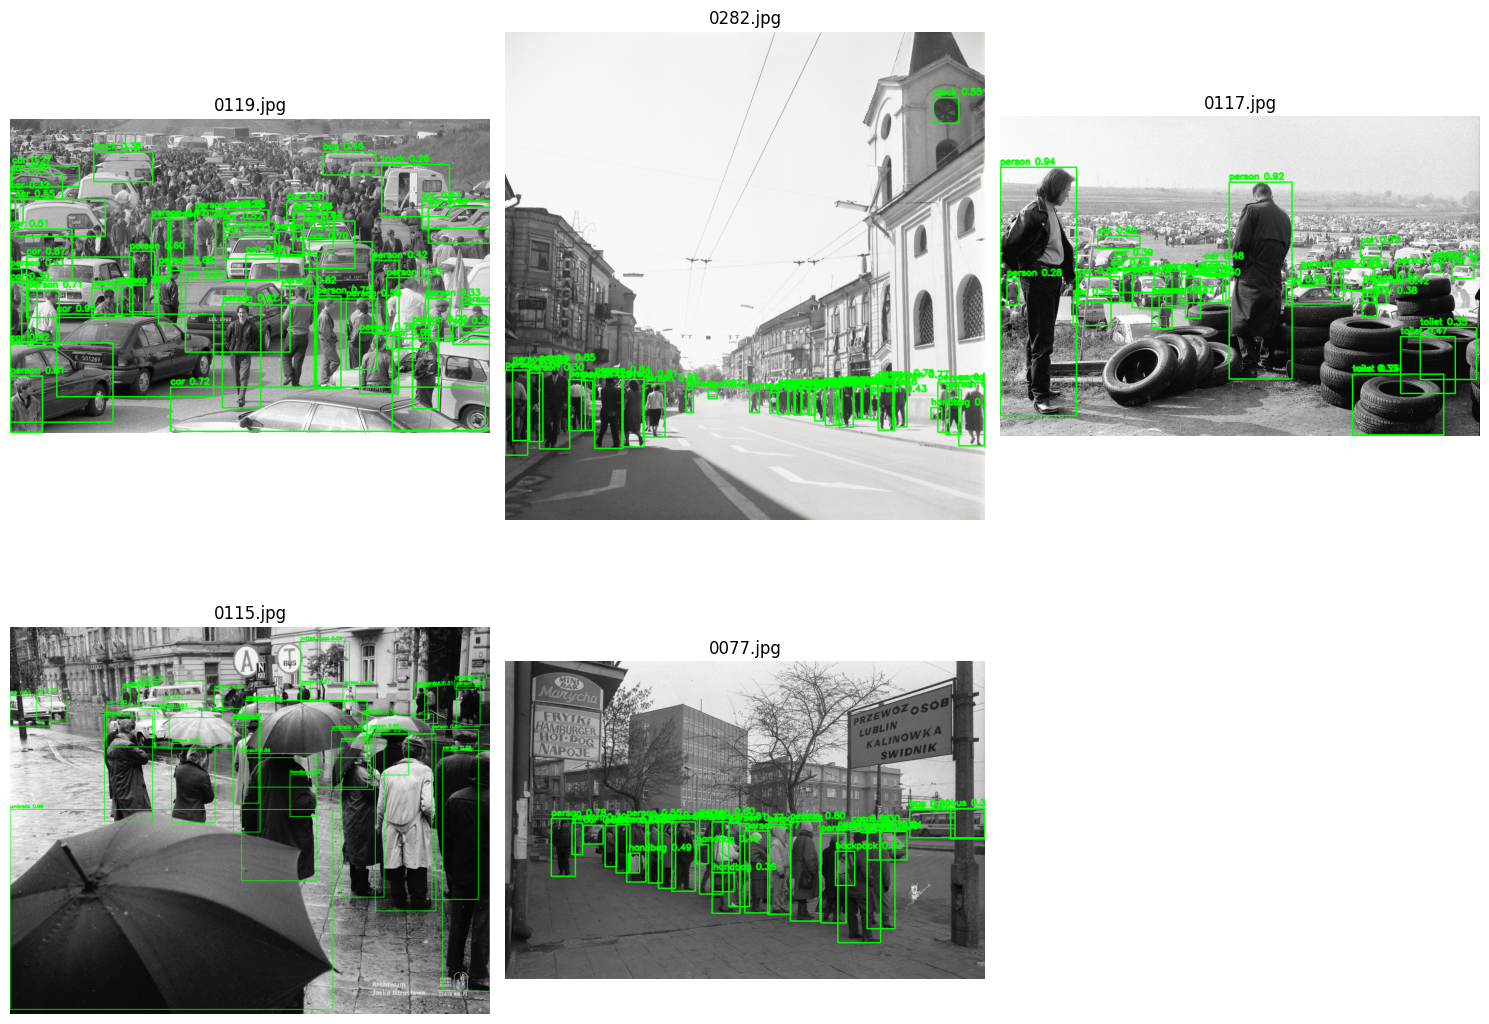

In [6]:
### 5. Podsumowanie detekcji + wizualizacja 5 przykładów

import matplotlib.pyplot as plt
import numpy as np

# --- globalne podsumowanie klas ---
all_counts = {}

for counts in df_yolo["class_counts"]:
    for cls, n in counts.items():
        all_counts[cls] = all_counts.get(cls, 0) + n

summary = pd.Series(all_counts).sort_values(ascending=False)

print("=== Podsumowanie detekcji w całym folderze ===")
for cls, n in summary.items():
    print(f"{cls}: {n}")

# --- wybieramy 5 obrazów z największą liczbą detekcji ---
examples = (
    df_yolo.sort_values("n_detections", ascending=False)
           .head(5)
)["file_path"].tolist()

print("\nWybrane przykładowe obrazy:", examples)

# --- wizualizacja ---
plt.figure(figsize=(15, 12))

for i, img_path in enumerate(examples, start=1):
    orig, dets = run_yolo_on_image(img_path)
    vis = draw_detections(orig, dets)

    plt.subplot(2, 3, i)
    plt.imshow(vis)
    plt.title(Path(img_path).name)
    plt.axis("off")

plt.tight_layout()
plt.show()

### 6. Eksport wykrytych obiektów do CSV

In [7]:
### X. Sugestie subject (PL/EN) na podstawie YOLO i eksport do CSV

import pandas as pd
from ast import literal_eval
from pathlib import Path

# plik z batchowym wynikiem YOLO (komórka 4)
RESULTS_CSV = OUTPUT_CSV_DIR / "yolo_medium_results.csv"

# ============================
# SŁOWNIK EN → PL DLA KLAS YOLO
# (rozszerzysz w razie potrzeby)
# ============================
CLASS_PL = {
    "airplane": "samolot",
    "backpack": "plecak",
    "banana": "banan",
    "baseball bat": "kij baseballowy",
    "bear": "niedźwiedź",
    "bed": "łóżko",
    "bench": "ławka",
    "bicycle": "rower",
    "bird": "ptak",
    "book": "książka",
    "bottle": "butelka",
    "bowl": "miska",
    "bus": "autobus",
    "cake": "ciasto",
    "car": "samochód",
    "carrot": "marchewka",
    "cat": "kot",
    "cell phone": "telefon komórkowy",
    "chair": "krzesło",
    "clock": "zegar",
    "cow": "krowa",
    "cup": "kubek",
    "dog": "pies",
    "donut": "donut",
    "elephant": "słoń",
    "fire hydrant": "hydrant",
    "fork": "widelec",
    "frisbee": "frisbee",
    "giraffe": "żyrafa",
    "handbag": "torebka",
    "horse": "koń",
    "hot dog": "hot-dog",
    "keyboard": "klawiatura",
    "kite": "latawiec",
    "knife": "nóż",
    "laptop": "laptop",
    "microwave": "kuchenka mikrofalowa",
    "motorcycle": "motocykl",
    "mouse": "mysz",
    "orange": "pomarańcza",
    "oven": "piekarnik",
    "parking meter": "parkometr",
    "person": "osoba",
    "pizza": "pizza",
    "potted plant": "roślina w doniczce",
    "refrigerator": "lodówka",
    "remote": "pilot",
    "sandwich": "kanapka",
    "scissors": "nożyczki",
    "sheep": "owca",
    "sink": "zlew",
    "sports ball": "piłka sportowa",
    "stop sign": "znak stop",
    "suitcase": "walizka",
    "tennis racket": "rakieta tenisowa",
    "tie": "krawat",
    "toilet": "toaleta",
    "traffic light": "sygnalizator świetlny",
    "train": "pociąg",
    "truck": "ciężarówka",
    "tv": "telewizor",
    "umbrella": "parasol",
    "vase": "wazon",
}

# 1) wczytanie wyników YOLO (jeśli df_yolo nie jest w pamięci)
if "df_yolo" not in globals():
    if not RESULTS_CSV.exists():
        raise FileNotFoundError(f"Brak pliku: {RESULTS_CSV}")
    df_yolo = pd.read_csv(
        RESULTS_CSV,
        converters={
            "classes": literal_eval,      # listy klas
            "class_counts": literal_eval  # słowniki {klasa: liczba}
        }
    )

# 2) funkcja: listę klas EN → subject_en + subject_pl
def classes_to_subjects(class_list):
    if not isinstance(class_list, list):
        return pd.Series({"subject_en": "", "subject_pl": ""})

    unique_en = sorted(set(class_list))
    subject_en = "; ".join(unique_en)

    pl_names = [CLASS_PL[c] for c in unique_en if c in CLASS_PL]
    subject_pl = "; ".join(pl_names) if pl_names else ""

    return pd.Series({"subject_en": subject_en, "subject_pl": subject_pl})

# 3) agregacja: jedno zdjęcie → jedna para subject_en / subject_pl
#    + file_name jako pierwsza kolumna (zamiast file_path)
df_subj = df_yolo[["file_path", "classes"]].copy()
df_subj["file_name"] = df_subj["file_path"].apply(lambda p: Path(p).name)
subj_cols = df_subj["classes"].apply(classes_to_subjects)
df_subj = pd.concat([df_subj[["file_name"]], subj_cols], axis=1)

# 4) zapis CSV
SUBJECT_CSV = OUTPUT_CSV_DIR / "yolo_subject_suggestions.csv"
df_subj.to_csv(SUBJECT_CSV, index=False)

print("Zapisano sugestie subject do:", SUBJECT_CSV)
df_subj.head()

Zapisano sugestie subject do: /Users/olga/MetaLogic/outputs/csv/yolo_subject_suggestions.csv


,file_name,subject_en,subject_pl
0,0000.jpg,bus; car; person; truck,autobus; samochód; osoba; ciężarówka
1,000202.jpg,car; person; truck,samochód; osoba; ciężarówka
2,000238.jpg,car,samochód
3,0003.jpg,car; person; tie; truck,samochód; osoba; krawat; ciężarówka
4,000345.jpg,car; person,samochód; osoba


### Nota: trening YOLO dla własnych obiektów

Aby wytrenować YOLO (m/l) do wykrywania obiektów typu *Syrena*, *kiosk RUCH*:

- zdefiniuj klasy (np. `syrena`, `kiosk_ruch`)
- zbierz zdjęcia (200–500/klasę)
- wykonaj ręczną anotację bounding boxów w Label Studio (eksport: YOLO TXT)
- przygotuj strukturę datasetu:

        dataset/images/train, val
        dataset/labels/train, val

- utwórz `data.yaml` (ścieżki + lista klas)
- trenuj:

        yolo detect train model=yolo11m.pt data=data.yaml imgsz=1024 epochs=100